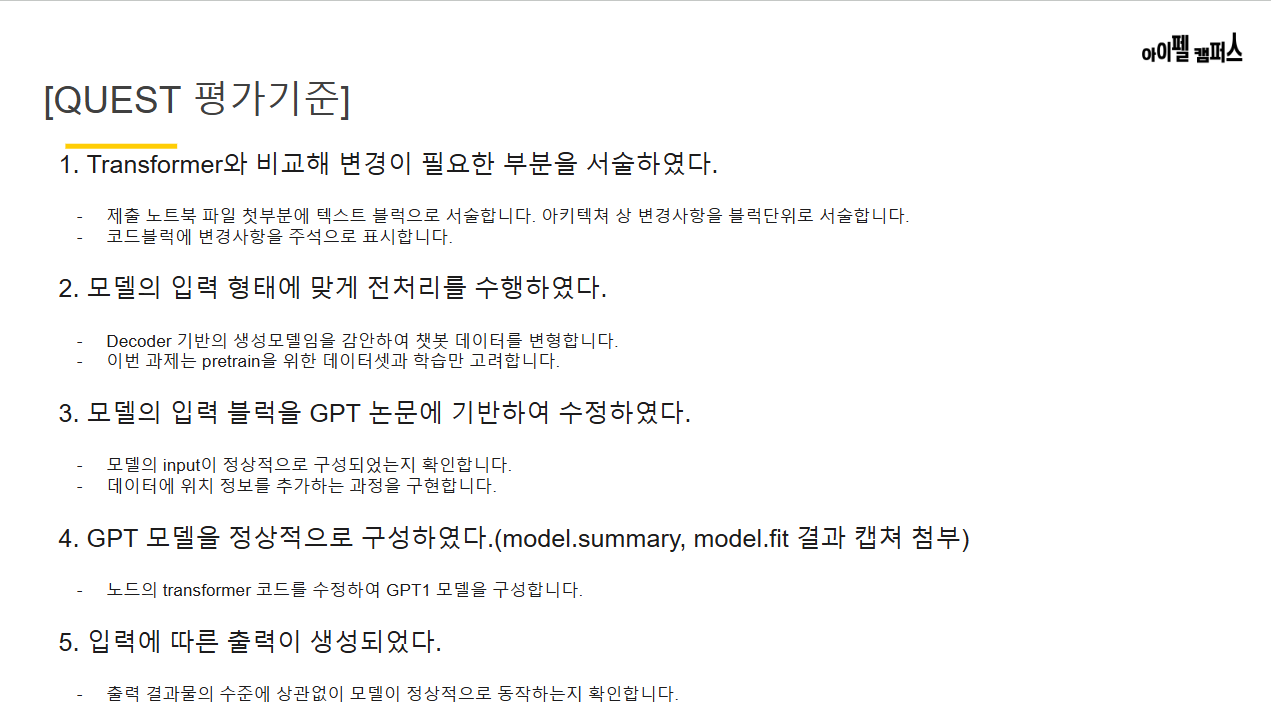

In [ ]:
image_path = '/content/drive/MyDrive/aiffel/Data/아이펠MAINQUEST.png'
image = cv2.imread(image_path)
cv2_imshow(image)

# **1. 변경점 서술**


## **Transformer VS GPT**

* 가장 큰 특징은 인코더의 유무이다.
* 인코더의 context를 참조하냐-안하냐에서 파생되는 여러가지 차이점을 가져온다.

### **Scaled Dot Product Attention & MultiHeadAttention**
* Scaled Dot Product Attention 부분과 MultiHeadAttention 부분은 내가 EX06에서 구현했던 트랜스포머와 동일하다.
    * 사실 당연하다. 디코더에도 공통으로 쓰이니까.

### **Positional**
* Transformer에서는 포지셔널 인코딩이 사용되었으나
* GPT에서는 임베딩 레이어가 사용되었다.
#### **추측**
* Transformer에선 순환신경망에서 위치정보를 전달하겠다는 측면에 중점을 두었기에 임베딩을 굳이 쓰지 않았을 듯
* GPT에서는 빅데이터를 처리해야하기에 임베딩 레이어를 도입해야 했을 것

### **Masking**
* Transformer에서는 Look-Ahead Mask와 padding_mask(패딩을 건너뛰는) 기법이 사용되었다.
    * 인코더에선 padding_mask만, 디코더에선 Look-Ahead Mask와 padding_mask 둘 다 사용
* GPT에서는 Look-Ahead Mask(디코더가 다음 단어를 참조하지 못하게)하는 기법만 사용되었다.
    * autoregressive라는 특성을 유지하여 다음 단어를 생성해야하기 때문
    * 또, 문장 전체의 문맥을 이해하는 인코더의 부재로 padding mask가 필요없게 되었다고 한다. 디코더가 인코더를 참조할 일이 없기에.
    * 단, 특정 구현에 있어서는 padding mask가 필요할수도 있다고 한다.

### **Feed Forward Network**

* 두 모델 다 동일하다.

### **핵심 층 연산 구조**

* 멀티헤드어텐션을 통과하고 잔차연결 정규화
* ffn(point_wise_feed_forward_network)을 통과하고 잔차연결 정규화
* 동일하다.

### **디코더 구조**

* Transformer 디코더는 이전 시점까지 생성했던 단어들과 인코더의 output을 input으로 받는다
* GPT는 인코더가 없기에 이전 시점까지 생성했던 단어들만 input으로 받는다.
* AR이냐, seq2seq냐에서 오는 근본적인 차이가 있다.

### **그 외**

* 디코더의 개수 등 파라미터 차이가 있겠다.
* gpt는 라벨이 없는 비지도학습이다. 자기 자신의 text만 활용.
* Transformer도 라벨을 받지는 않지만, 인코더의 context를 정보로 활용한다.


# **2. 모델 입력에 맞게 전처리**

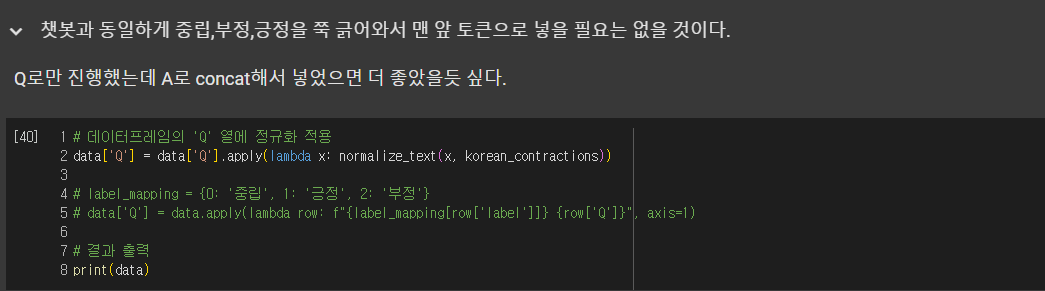

In [ ]:
image_path = '/content/drive/MyDrive/aiffel/Data/preprocessing.png'
image = cv2.imread(image_path)
cv2_imshow(image)

# **3. 모델을 GPT논문에 기반하여 수정**

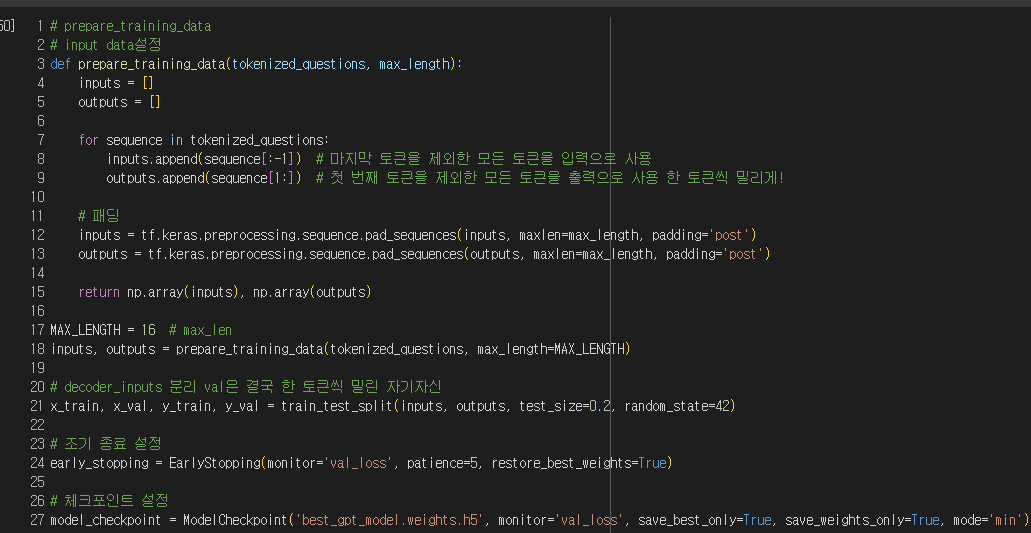

In [ ]:
image_path = '/content/drive/MyDrive/aiffel/Data/input data.png'
image = cv2.imread(image_path)
cv2_imshow(image)

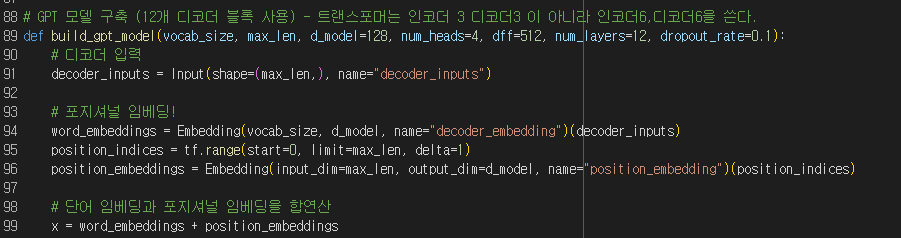

In [ ]:
image_path = '/content/drive/MyDrive/aiffel/Data/positional.png'
image = cv2.imread(image_path)
cv2_imshow(image)

# **4.모델 정상 구현**

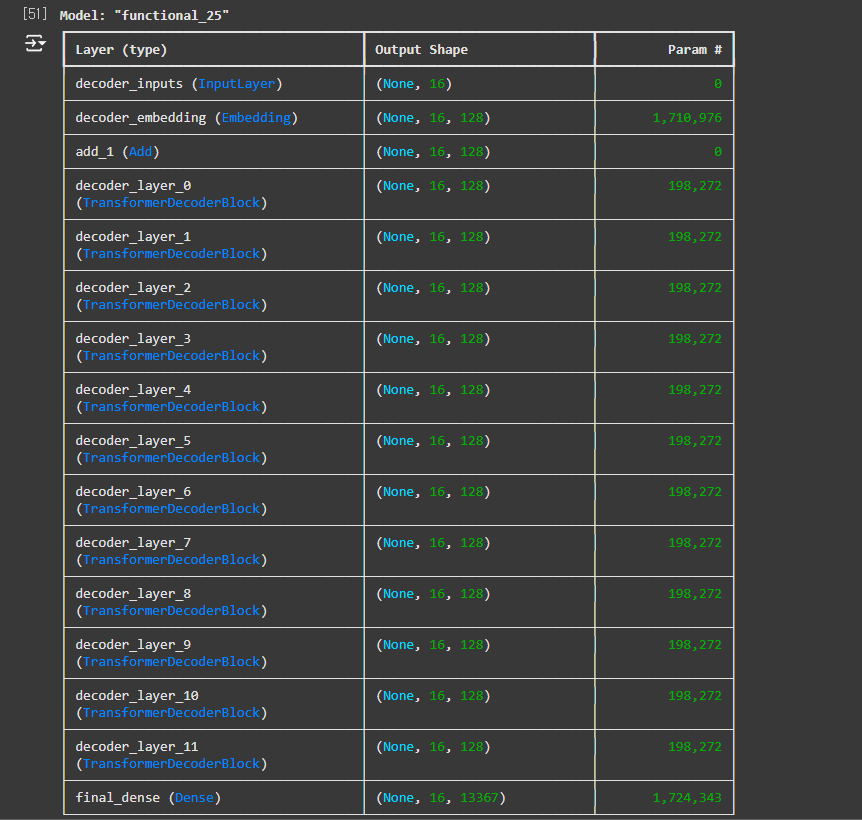

In [ ]:
image_path = '/content/drive/MyDrive/aiffel/Data/model_summary.png'
image = cv2.imread(image_path)
cv2_imshow(image)

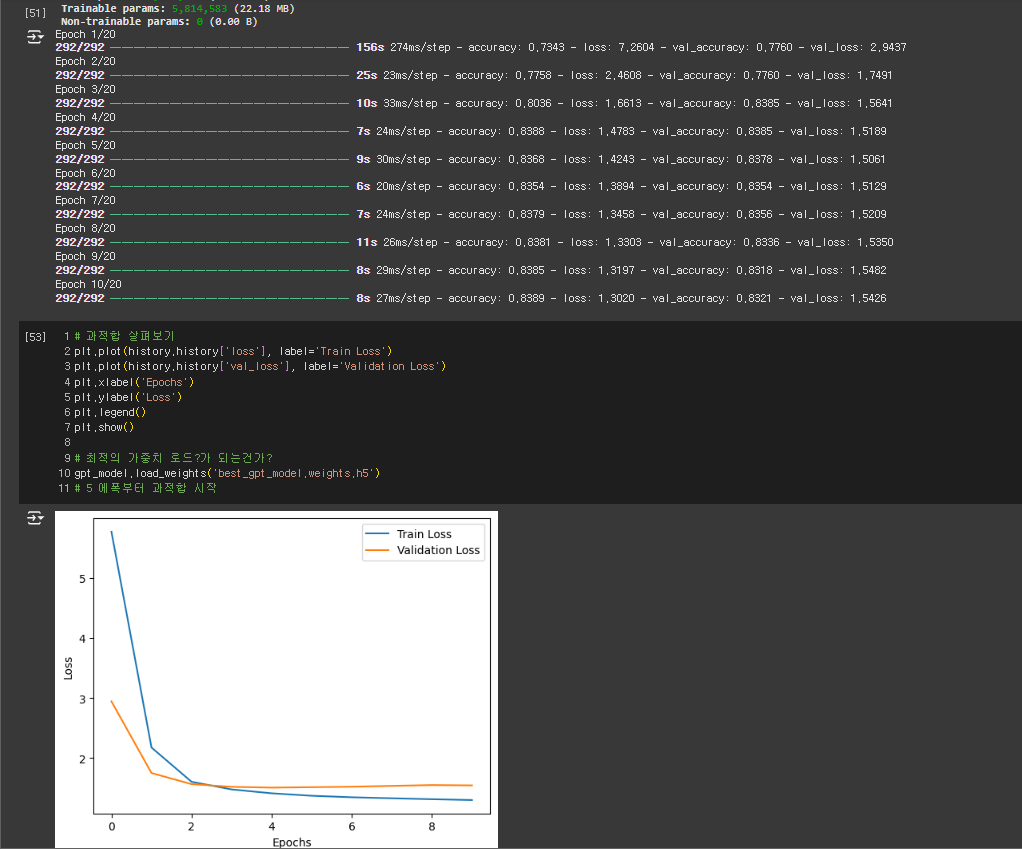

In [ ]:
image_path = '/content/drive/MyDrive/aiffel/Data/model_fit.png'
image = cv2.imread(image_path)
cv2_imshow(image)

# **5. 출력확인**

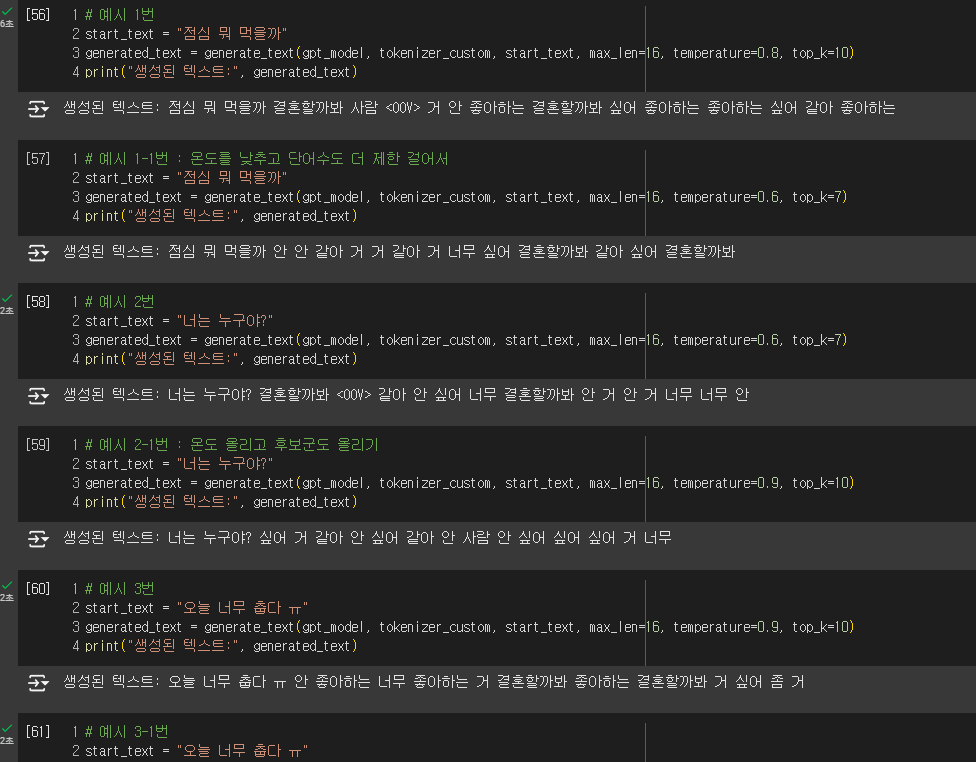

In [ ]:
image_path = '/content/drive/MyDrive/aiffel/Data/generate.png'
image = cv2.imread(image_path)
cv2_imshow(image)

### 데이터 전처리
* 아래 데이터에서 Q부분만을 넣어보자. GPT 디코더에서 활용해보자

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Dropout, Lambda, Add, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import re
import tensorflow_datasets as tfds

# 경고무시
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(tf.__version__)

2.17.1


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/aiffel/Data/ChatbotData.csv")
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Q'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 11662


In [ ]:
data.drop_duplicates(subset = ['Q'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 11662


In [ ]:
data.isnull().sum()

,0
Q,0
A,0
label,0


In [ ]:
korean_contractions = {
    "맘": "마음",
    "가바": "가봐",
    "그런건가바": "그런 건가 봐",
    "배고프당": "배고프다",
    "졸리당": "졸리다",
    "몰겠엉": "모르겠어",
    "맛있엉": "맛있어",
    "ㅂㅂ": "바이바이",
    "ㅎㅇ": "안녕하세요",
    "안녕ㅎㅇ": "안녕하세요",
    "ㅋㅋ": "웃음",
    "ㅠㅠ": "슬픔",
    "ㅇㅇ": "응",
    "ㅈㅅ": "죄송",
    "ㅁㄹ": "모르겠어",
    "넘": "너무",
    "귀찮앙": "귀찮아",
    "고마웡": "고마워",
    "미안행": "미안해",
    "알겠엉": "알겠어",
    "안뇽": "안녕하세요",
    "하쥬": "하죠",
    "이게모얌": "이게 뭐야",
    "졸려죽겟다": "졸려 죽겠다",
    "재밋어": "재미있어",
    "재밋엇다": "재미있었다",
    "힘드러": "힘들어",
    "잘될꺼야": "잘 될 거야",
    "배고파죽겟어": "배고파 죽겠어",
    "뭐하냥": "뭐하니",
    "하루종일잇었엉": "하루 종일 있었어",
    "괜찮을깡": "괜찮을까",
    "모르겟다": "모르겠다",
    "먹엇어": "먹었어",
    "피곤해죽겟어": "피곤해 죽겠어",
    "ㄱㄷ": "기다려",
    "ㄱㅅ": "감사",
    "ㄴㄴ": "아니야",
    "ㄱㅇㄷ": "개이득",
    "ㅎㄹ": "할래",
    "ㅊㅋ": "축하",
    "이해안대": "이해 안 돼",
    "잘자용": "잘 자",
    "ㅂㅇㅂㅇ": "바이바이",
    "감동이얌": "감동이야",
    "빠이": "안녕",
    "몰루": "몰라",
    "넘좋아": "너무 좋아",
    "쫌만더": "조금만 더",
    "심심해쥬금": "심심해 죽겠음",
    "알았엉": "알았어",
    "피곤해쥬금": "피곤해 죽겠음",
    "기달려": "기다려",
    "그랬엉": "그랬어",
    "졸려죽겟음": "졸려 죽겠음",
    "도와줘잉": "도와줘",
    "배아파쥬금": "배 아파 죽겠음",
    "배불러죽겟어": "배불러 죽겠어",
    "행복해쥬금": "행복해 죽겠어",
    "맛없엉": "맛없어",
    "피곤햌": "피곤해",
    "귀찮아용": "귀찮아",
    "미치겟다": "미치겠다",
    "좋아햌": "좋아해",
    "재밋겟당": "재미있겠다",
    "잘잇어": "잘 있어",
    "오랜만이얌": "오랜만이야",
    "대박이얌": "대박이야",
    "웃기당": "웃기다",
    "졸귀": "졸라 귀여워",
    "행쇼": "행복하자",
    "안믿겟다": "안 믿겠다",
    "모햌": "뭐해",
    "배고팡": "배고파",
    "슬프당": "슬프다",
    "귀찮앜": "귀찮아",
    "졸립다": "졸리다",
    "머해": "뭐해",
    "놀자아": "놀자",
    "알겟엉": "알겠어",
    "반가웡": "반가워",
    "어케해": "어떻게 해",
    "배불러옹": "배불러",
    "오키": "오케이",
    "뭐해용": "뭐해",
    "행복햌": "행복해",
    "쩐다": "대단하다",
    "빨리해줘": "빨리 해줘",
    "나쫌졸려": "나 좀 졸려",
    "짱나": "짜증나",
    "놀고싶당": "놀고 싶다",
    "모르겟엉": "모르겠어",
    "졸려어": "졸려",
    "그럴껄": "그럴 걸",
    "밥먹엇니": "밥 먹었니",
    "뭐드셧어요": "뭐 드셨어요",
    "맛있어보엉": "맛있어 보여",
    "나힘들어ㅠ": "나 힘들어",
    "배부르당": "배부르다",
    "웃기넼": "웃기네",
    "이해안됨": "이해 안 돼",
    "졸림": "졸려",
    "집에갈랭": "집에 갈래",
    "덥다아": "덥다",
    "좋겠다아": "좋겠다",
    "심심햌": "심심해",
    "집가고싶엉": "집 가고 싶어",
    "뭐임": "뭐야",
    "미쳣다": "미쳤다",
    "오랫만": "오랜만",
    "어케알았어": "어떻게 알았어",
    "신기하당": "신기하다",
    "조심하세용": "조심하세요",
    "잼잇당": "재미있다",
    "심심하당": "심심하다",
    "감사합니당": "감사합니다",
    "감동이얌": "감동이야",
    "피곤해욤": "피곤해요",
    "알앗어": "알았어",
    "즐겁당": "즐겁다",
    "귀여웡": "귀여워",
    "힘들엉": "힘들어",
    "속상해쥬금": "속상해 죽겠음",
    "아깝당": "아깝다",
    "잘못햇어": "잘못했어",
    "이뻐용": "예뻐요",
    "맛있겠당": "맛있겠다",
    "멋져용": "멋져요",
    "좋아욤": "좋아요",
    "졸린다아": "졸린다",
    "보고싶당": "보고 싶다",
    "힘들다아": "힘들다",
    "이해했엉": "이해했어",
    "맛나보엉": "맛나 보여",
    "웃곀": "웃겨",
    "귀찮군": "귀찮아",
    "보고싶엉": "보고 싶어",
    "짜증난당": "짜증난다",
    "잘될꺼얌": "잘 될 거야",
    "잘잤엉": "잘 잤어",
    "졸리웡": "졸려",
    "미안혀": "미안해",
    "힘내세욤": "힘내세요",
    "졸린당": "졸리다",
    "모르겟삼": "모르겠다",
    "빨리와": "빨리 와",
    "헐대박": "정말 대단하다",
    "놀랫자나": "놀랐잖아",
    "기여워": "귀여워",
    "심심해요ㅠ": "심심해요",
    "사랑햌": "사랑해",
    "어이엄슴": "어이없음",
    "몰라욤": "몰라요",
    "뭥미": "뭐임",
    "덥당": "덥다",
    "추웡": "추워",
    "대단하당": "대단하다",
    "기다리쥬": "기다려줘",
    "뭐하냥용": "뭐하니",
    "못참겟어": "못 참겠어",
    "미쳤넼": "미쳤네",
    "졸려죽겟엉": "졸려 죽겠어"
}

# 정규화 함수
def normalize_text(text, contractions_dict):
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
    return text

#### 챗봇과 동일하게 중립,부정,긍정을 쭉 긁어와서 맨 앞 토큰으로 넣을 필요는 없을 것이다.

#### Q로만 진행했는데 A로 concat해서 넣었으면 더 좋았을듯 싶다.


In [ ]:
# 데이터프레임의 'Q' 열에 정규화 적용
data['Q'] = data['Q'].apply(lambda x: normalize_text(x, korean_contractions))

# label_mapping = {0: '중립', 1: '긍정', 2: '부정'}
# data['Q'] = data.apply(lambda row: f"{label_mapping[row['label']]} {row['Q']}", axis=1)

# 결과 출력
print(data)

                             Q                         A  label
0                       12시 땡!                하루가 또 가네요.      0
1                  1지망 학교 떨어졌어                 위로해 드립니다.      0
2                 3박4일 놀러가고 싶다               여행은 언제나 좋죠.      0
3              3박4일 정도 놀러가고 싶다               여행은 언제나 좋죠.      0
4                      PPL 심하네                눈살이 찌푸려지죠.      0
...                        ...                       ...    ...
11817            후회 없이 사랑하고 싶어             진심으로 다가가 보세요.      2
11818           훔쳐보는 것도 눈치 보임.        티가 나니까 눈치가 보이는 거죠!      2
11820              흑기사 해주는 짝남.                    설렜겠어요.      2
11821  힘든 연애 좋은 연애라는게 무슨 차이일까?  잘 헤어질 수 있는 사이 여부인 거 같아요.      2
11822               힘들어서 결혼할까봐        도피성 결혼은 하지 않길 바라요.      2

[11662 rows x 3 columns]


In [ ]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 양쪽 공백을 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'["]+', " ", sentence)

    # (ㄱ-ㅎ, 가-힣, a-z, A-Z, 0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백으로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

# data['Q'] 전처리
def load_questions(data):
    inputs = []
    for q in data['Q']:
        preprocessed_q = preprocess_sentence(q)
        inputs.append(preprocessed_q)
    return inputs

# 전처리 결과를 questions에 저장
questions = load_questions(data)

print('전체 샘플 수 :', len(questions))

# 예시 출력
print("전처리된 질문 예시:", questions[:3])

전체 샘플 수 : 11662
전처리된 질문 예시: ['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다']


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# 단어 사전 생성
tokenizer_custom = Tokenizer(num_words=20000, oov_token='<OOV>')  # 최대 20000개로 잡고 OOV 처리
tokenizer_custom.fit_on_texts(questions) # 리스트

# 단어 사전의 크기
vocab_size_custom = len(tokenizer_custom.word_index) + 1  # +1은 padding을 위한 0 인덱스 추가
print('단어 사전 크기:', vocab_size_custom)

# 인코딩
encoded_questions_custom = tokenizer_custom.texts_to_sequences(questions)

# 종료 토큰 추가
END_TOKEN = vocab_size_custom - 1  # 종료 토큰의 인덱스를 단어 사전의 마지막 인덱스로 추가
encoded_questions_custom = [q + [END_TOKEN] for q in encoded_questions_custom]

# 정수 인코딩 확인
print('인코딩 확인:', encoded_questions_custom[0])

question_lengths_custom = [len(encoded_q) for encoded_q in encoded_questions_custom]

# 최대 길이
max_len_questions_custom = max(question_lengths_custom)
print('Q 최대 길이 (토큰 기준):', max_len_questions_custom)

단어 사전 크기: 13367
인코딩 확인: [4558, 4559, 13366]
Q 최대 길이 (토큰 기준): 16


In [ ]:
MAX_LENGTH = 16

In [ ]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
# 의미없음
def tokenize_and_filter_questions(questions):
    tokenized_questions = []

    for sentence in questions:
        # 정수 인코딩 과정에서 종료 토큰을 추가 (시작 토큰은 불필요하므로 제외)
        sentence = tokenizer.encode(sentence, add_special_tokens=False) + END_TOKEN

        # 최대 길이 16 이하인 경우에만 데이터셋으로 허용
        if len(sentence) <= MAX_LENGTH:
            tokenized_questions.append(sentence)

    # 최대 길이 16으로 모든 데이터셋을 패딩
    tokenized_questions = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_questions, maxlen=MAX_LENGTH, padding='post')

    return tokenized_questions

In [ ]:
tokenized_questions = tf.keras.preprocessing.sequence.pad_sequences(
    encoded_questions_custom, maxlen=MAX_LENGTH, padding='post'
)

# 결과 확인
print('패딩 결과:', tokenized_questions[0])
print('패딩 후 길이:', len(tokenized_questions[0]))

패딩 결과: [ 4558  4559 13366     0     0     0     0     0     0     0     0     0
     0     0     0     0]
패딩 후 길이: 16


In [ ]:
# 전부 적용한 최종본
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Scaled Dot Product Attention 벡터 내적으로 key value query 스칼라 스코어 계산하는 식
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        mask = tf.cast(mask, dtype=scaled_attention_logits.dtype)
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

# Multi-Head Attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads
        self.wq = Dense(d_model, name="wq_dense")
        self.wk = Dense(d_model, name="wk_dense")
        self.wv = Dense(d_model, name="wv_dense")
        self.dense = Dense(d_model, name="output_dense")

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)
        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        return self.dense(concat_attention)


# Look-Ahead Mask 생성 함수 padding mask가 적용되지 않는다!
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

# Feed Forward Network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        Dense(dff, activation='relu', name="ffn_dense_1"),
        Dense(d_model, name="ffn_dense_2")
    ])

# Transformer의 디코더 블록 - 변형
# 형태는 같다. 다만, 인코더가 없는 구조기에 해당 블록은 디코더에서만 사용될 것!
class TransformerDecoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name=None):
        super(TransformerDecoderBlock, self).__init__(name=name)
        self.mha = MultiHeadAttention(d_model, num_heads, name=f"multi_head_attention_{name}")
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=1e-6, name=f"layernorm1_{name}")
        self.layernorm2 = LayerNormalization(epsilon=1e-6, name=f"layernorm2_{name}")
        self.dropout1 = Dropout(rate, name=f"dropout1_{name}")
        self.dropout2 = Dropout(rate, name=f"dropout2_{name}")

    def call(self, x, mask=None):
        # Multi-Head Attention
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        # Feed Forward Network (FFN)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# GPT 모델 구축 (12개 디코더 블록 사용) - 트랜스포머는 인코더 3 디코더3 이 아니라 인코더6,디코더6을 쓴다.
def build_gpt_model(vocab_size, max_len, d_model=128, num_heads=4, dff=512, num_layers=12, dropout_rate=0.1):
    # 디코더 입력
    decoder_inputs = Input(shape=(max_len,), name="decoder_inputs")

    # 포지셔널 임베딩!
    word_embeddings = Embedding(vocab_size, d_model, name="decoder_embedding")(decoder_inputs)
    position_indices = tf.range(start=0, limit=max_len, delta=1)
    position_embeddings = Embedding(input_dim=max_len, output_dim=d_model, name="position_embedding")(position_indices)

    # 단어 임베딩과 포지셔널 임베딩을 합연산
    x = word_embeddings + position_embeddings

    # Look-Ahead Mask
    look_ahead_mask = create_look_ahead_mask(max_len)

    # 12개 디코더 블록
    for i in range(num_layers):
        x = TransformerDecoderBlock(d_model, num_heads, dff, rate=dropout_rate, name=f"decoder_layer_{i}")(x, mask=look_ahead_mask)

    # softmax 출력 레이어
    final_output = Dense(vocab_size, activation='softmax', name="final_dense")(x)

    # 모델 return
    return Model(inputs=decoder_inputs, outputs=final_output)

In [ ]:
# prepare_training_data
# input data설정
def prepare_training_data(tokenized_questions, max_length):
    inputs = []
    outputs = []

    for sequence in tokenized_questions:
        inputs.append(sequence[:-1])  # 마지막 토큰을 제외한 모든 토큰을 입력으로 사용
        outputs.append(sequence[1:])  # 첫 번째 토큰을 제외한 모든 토큰을 출력으로 사용 한 토큰씩 밀리게!

    # 패딩
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_length, padding='post')
    outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs, maxlen=max_length, padding='post')

    return np.array(inputs), np.array(outputs)

MAX_LENGTH = 16  # max_len
inputs, outputs = prepare_training_data(tokenized_questions, max_length=MAX_LENGTH)

# decoder_inputs 분리 val은 결국 한 토큰씩 밀린 자기자신
x_train, x_val, y_train, y_val = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 체크포인트 설정
model_checkpoint = ModelCheckpoint('best_gpt_model.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')

In [ ]:
# 하이퍼파라미터 설정
vocab_size = vocab_size_custom   # 챗폿 데이터 단어 사전 크기
max_len = MAX_LENGTH # 모델의 입력 길이
d_model = 128        # 임베딩 차원 수
num_heads = 8        # Multi-Head Attention 헤드 수
dff = 512            # FFN 내부 차원 수
num_layers = 12      # 디코더 블록 개수
dropout_rate = 0.2   # 드롭아웃 비율

# GPT1 기준! 파라미터가 억 단위로 올라간다. 셀 터짐 or 데이터 학습이 바로 과적합
# vacab_size = 40000 # 단어사전 수
# d_model = 768      # 임베딩 차원 수
# num_heads = 12     # Multi-Head Attention 헤드 수
# dff = 3072         # FFN 내부 차원 수
# num_layers = 12    # 디코더 블록 개수
# dropout_rate = 0.1 # 드롭아웃 비율

# 컴파일
gpt_model = build_gpt_model(vocab_size, MAX_LENGTH, d_model, num_heads, dff, num_layers, dropout_rate)
gpt_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 모델 구조
gpt_model.summary()

# 모델 학습

history = gpt_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_inputs (InputLayer)          │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_embedding (Embedding)        │ (None, 16, 128)             │       1,710,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_1 (Add)                          │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_0                      │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_1                      │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_2                      │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_3                      │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_4                      │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_5                      │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_6                      │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_7                      │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_8                      │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_9                      │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_10                     │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_11                     │ (None, 16, 128)             │         198,272 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,814,583 (22.18 MB)

 Trainable params: 5,814,583 (22.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 156s 274ms/step - accuracy: 0.7343 - loss: 7.2604 - val_accuracy: 0.7760 - val_loss: 2.9437
Epoch 2/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.7758 - loss: 2.4608 - val_accuracy: 0.7760 - val_loss: 1.7491
Epoch 3/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8036 - loss: 1.6613 - val_accuracy: 0.8385 - val_loss: 1.5641
Epoch 4/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8388 - loss: 1.4783 - val_accuracy: 0.8385 - val_loss: 1.5189
Epoch 5/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8368 - loss: 1.4243 - val_accuracy: 0.8378 - val_loss: 1.5061
Epoch 6/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8354 - loss: 1.3894 - val_accuracy: 0.8354 - val_loss: 1.5129
Epoch 7/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8379 - loss: 1.3458 - val_accuracy: 0.8356 - val_loss: 1.5209
Epoch 8/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8381 - loss: 1.3303 - va

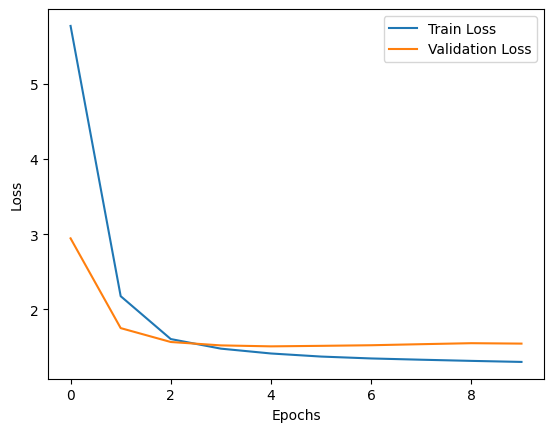

In [ ]:
# 과적합 살펴보기
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 최적의 가중치 로드?가 되는건가?
gpt_model.load_weights('best_gpt_model.weights.h5')
# 5 에폭부터 과적합 시작

In [ ]:
import numpy as np
import tensorflow as tf

def generate_text(model, tokenizer, start_text, max_len=17, temperature=1.0, top_k=10):
    """
    prepare_training GPT 모델을 사용하여 텍스트를 생성
    - model = 학습된 GPT 모델
    - tokenizer = 커스텀 단어 사전 기반 토크나이저
    - start_text = 시작 시드 텍스트
    - max_len = 생성할 최대 토큰 수
    - 다양성 및 제한 추가
    - temperature = 샘플링의 랜덤성을 제어하는 온도 매개변수
    - top_k = 상위 k개의 단어 중 하나를 선택하여 생성
    """
    # 인코딩
    input_ids = tokenizer.texts_to_sequences([start_text])[0]
    input_ids = tf.keras.preprocessing.sequence.pad_sequences([input_ids], maxlen=max_len, padding='post')
    input_ids = tf.convert_to_tensor(input_ids, dtype=tf.int32)  # 배치 차원

    generated_text = start_text # 생성초기화

    # AR
    for _ in range(max_len - len(start_text.split())):
        # Look-ahead mask 적용하기 위해
        input_len = tf.shape(input_ids)[1]
        look_ahead_mask = create_look_ahead_mask(input_len)

        # 모델 예측 생성
        predictions = model(input_ids, training=False)
        next_token_logits = predictions[:, -1, :]  # 마지막 토큰에 대한 예측값 추출

        # Temperature 적용
        next_token_logits = next_token_logits / temperature

        # 상위 k개 후보 군 중에서 선택하게
        top_k_indices = tf.math.top_k(next_token_logits, k=top_k).indices.numpy()[0]
        next_token = np.random.choice(top_k_indices)

        # 생성된 토큰을 입력에 추가하여 반복
        input_ids = tf.concat([input_ids[:, :-1], [[next_token]]], axis=-1)  # 길이를 유지하면서 새로운 토큰 추가

        # 생성된 단어 쭉 추가히기
        generated_word = tokenizer.sequences_to_texts([[next_token]])[0]
        generated_text += ' ' + generated_word

        # END_TOKEN 나오면 종료
        if next_token == (tokenizer.word_index.get('<END_TOKEN>', -1)):
            break

    return generated_text

In [ ]:
# 예시 1번
start_text = "점심 뭐 먹을까"
generated_text = generate_text(gpt_model, tokenizer_custom, start_text, max_len=16, temperature=0.8, top_k=10)
print("생성된 텍스트:", generated_text)

생성된 텍스트: 점심 뭐 먹을까 결혼할까봐 사람 <OOV> 거 안 좋아하는 결혼할까봐 싶어 좋아하는 좋아하는 싶어 같아 좋아하는


In [ ]:
# 예시 1-1번 : 온도를 낮추고 단어수도 더 제한 걸어서
start_text = "점심 뭐 먹을까"
generated_text = generate_text(gpt_model, tokenizer_custom, start_text, max_len=16, temperature=0.6, top_k=7)
print("생성된 텍스트:", generated_text)

생성된 텍스트: 점심 뭐 먹을까 안 안 같아 거 거 같아 거 너무 싶어 결혼할까봐 같아 싶어 결혼할까봐


In [ ]:
# 예시 2번
start_text = "너는 누구야?"
generated_text = generate_text(gpt_model, tokenizer_custom, start_text, max_len=16, temperature=0.6, top_k=7)
print("생성된 텍스트:", generated_text)

생성된 텍스트: 너는 누구야? 결혼할까봐 <OOV> 같아 안 싶어 너무 결혼할까봐 안 거 안 거 너무 너무 안


In [ ]:
# 예시 2-1번 : 온도 올리고 후보군도 올리기
start_text = "너는 누구야?"
generated_text = generate_text(gpt_model, tokenizer_custom, start_text, max_len=16, temperature=0.9, top_k=10)
print("생성된 텍스트:", generated_text)

생성된 텍스트: 너는 누구야? 싶어 거 같아 안 싶어 같아 안 사람 안 싶어 싶어 싶어 거 너무


In [ ]:
# 예시 3번
start_text = "오늘 너무 춥다 ㅠ"
generated_text = generate_text(gpt_model, tokenizer_custom, start_text, max_len=16, temperature=0.9, top_k=10)
print("생성된 텍스트:", generated_text)

생성된 텍스트: 오늘 너무 춥다 ㅠ 안 좋아하는 너무 좋아하는 거 결혼할까봐 좋아하는 결혼할까봐 거 싶어 좀 거


In [ ]:
# 예시 3-1번
start_text = "오늘 너무 춥다 ㅠ"
generated_text = generate_text(gpt_model, tokenizer_custom, start_text, max_len=16, temperature=1.2, top_k=10)
print("생성된 텍스트:", generated_text)

생성된 텍스트: 오늘 너무 춥다 ㅠ 싶어 좀 같아 거 좀 싶어 너무 <OOV> 같아 사람 결혼할까봐 안


In [ ]:
# 데이터가 너무 작다.
start_text = "여자친구랑 헤어졌어. 결혼 못 해"
generated_text = generate_text(gpt_model, tokenizer_custom, start_text, max_len=16, temperature=1.3, top_k=7)
print("생성된 텍스트:", generated_text)

생성된 텍스트: 여자친구랑 헤어졌어. 결혼 못 해 결혼할까봐 싶어 안 같아 거 안 안 거 같아 결혼할까봐 같아
